# Create an algorithm to detect North Atlantic right whale calls from audio recordings, prevent collisions with shipping traffic

Read the summary of the competition for a quick overview of the impact of the results.

We depend on shipping industry's uninterrupted ability to transport goods across long distances. Navigation technologies combine accurate position and environmental data to calculate optimal transport routes. Accounting for and reducing the impact of commercial shipping on the ocean’s environment, while achieving commercial sustainability, is of increasing importance, especially as it relates to the influence of cumulative noise “footprints” on the great whales.

Marinexplore is organizing the Planet's ocean data with the leading community of ocean professionals. One of the important datasets consists of acoustic recordings that can be used to detect species inhabiting the global ocean. Knowledge about animal locations can be utilized in industrial operations.

Cornell University's Bioacoustic Research Program has extensive experience in identifying endangered whale species and has deployed a 24/7 buoy network to guide ships from colliding with the world's last 400 North Atlantic right whales.

![System](https://kaggle2.blob.core.windows.net/competitions/kaggle/3353/media/kaggle_whale_detection_3.png)

Right whales make a half-dozen types of sounds, but the characteristic up-call is the one identified by the auto-detection buoys. The up-call is useful because it’s distinctive and right whales give it often. A type of “contact call,” the up-call is a little like small talk--the sound of a right whale going about its day and letting others know it’s nearby. In this recording the up-call is easy to hear--a deep, rising “whoop” that lasts about a second:


Marinexplore and Cornell researchers challenge YOU to beat the existing whale detection algorithm identifying the right whale calls. This will advance ship routing decisions in the region.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline
pd.options.mode.chained_assignment = None 

### Read in data

In [3]:
trainDf = pd.read_csv('data/train.csv')

In [4]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
clip_name    30000 non-null object
label        30000 non-null int64
dtypes: int64(1), object(1)
memory usage: 468.8+ KB


In [5]:
trainDf.label.sum()

7027

In [6]:
trainDf.shape

(30000, 2)

A total of 30000 sound recordings are labelled. Of these 7027 have been identified as whale recordings.

### Number of frames per second

In [7]:
import aifc

clips = list(trainDf.clip_name)

sig = aifc.open('data/train/train6.aiff', 'r')
strsig = sig.readframes(sig.getnframes())
y = np.fromstring(strsig,np.short).byteswap()

### We need to figure out the frame rate of the signal

In [8]:
sig.getframerate()

2000

### Get number of frames

In [9]:
N = sig.getnframes()

The framerate is 2000 frames per sec. So given that each sound recording clip contains 4000 frames, each recording is worth 2 s of data.

In [10]:
fs = sig.getframerate()
ts = 1.0/fs
t = np.arange(0,2,ts)

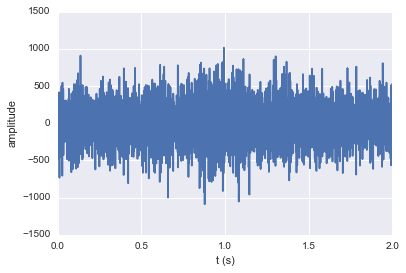

In [11]:
plt.plot(t,y)
plt.xlabel('t (s)')
plt.ylabel('amplitude')

### Look at the FFT

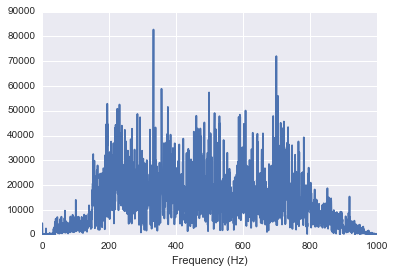

In [12]:
plt.plot(np.fft.fftfreq(y.shape[-1],ts)[:N/2], abs(np.fft.fft(y))[:N/2])
plt.xlabel('Frequency (Hz)')

## Plot a spectrogram to visualize the frequencies

A spectogram is created by chopping up the signal. Using the scipy spectogram function, we get...

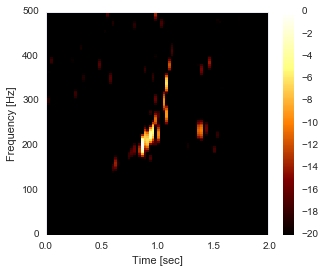

In [13]:
from scipy import signal
f, t, Sxx = signal.spectrogram(y, fs, nfft = 512, nperseg = 64, noverlap = 16, detrend = 'constant', scaling = 'spectrum')
plt.figure(figsize = (5,4))
Sxx = 20*np.log10(Sxx/Sxx.max())
Sxx[Sxx < -20] = -20
plt.pcolormesh(t, f[:128], Sxx[:128,:]  , cmap = 'afmhot')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()

#### Sum up the power spectrum across all frequencies.

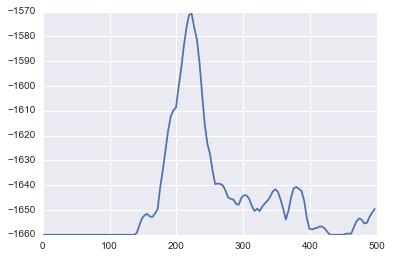

In [15]:
plt.plot(f[:128], np.sum(Sxx[:128,:], axis = 1))

So I think the frequency spectrum can be useful in detecting whales. I expect whales to have a frequency signature. So by binning the frequency spectrum we can engineer some features. For a start use the mean of values for every frequency as a feature.

## Do the test train split

In [16]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainDf.iloc[:,0], trainDf.iloc[:,1], test_size=0.33, random_state=42)

In [17]:
dictx = {}
for i in X_train.index:
    sig = aifc.open('data/train/'+X_train[i], 'r')
    strsig = sig.readframes(sig.getnframes())
    y = np.fromstring(strsig,np.short).byteswap()
    f, t, Sxx = signal.spectrogram(y, fs, nfft = 512, nperseg = 64, noverlap = 16, detrend = 'constant', scaling = 'spectrum')
    Sxx = 20*np.log10(Sxx/Sxx.max())
    Sxx[Sxx < -20] = -20
    #Sxx = abs(Sxx)
    dictx[i] = [arr.mean() for index, arr in enumerate(np.array_split(np.sum(Sxx[:128,:], axis = 1), 20))]


### Get some ML classification algos started

In [18]:
XtrainDf = pd.DataFrame.from_dict(dictx, orient = 'index')


In [19]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
XtrainDf.iloc[:] = scaler.fit_transform(XtrainDf.iloc[:])

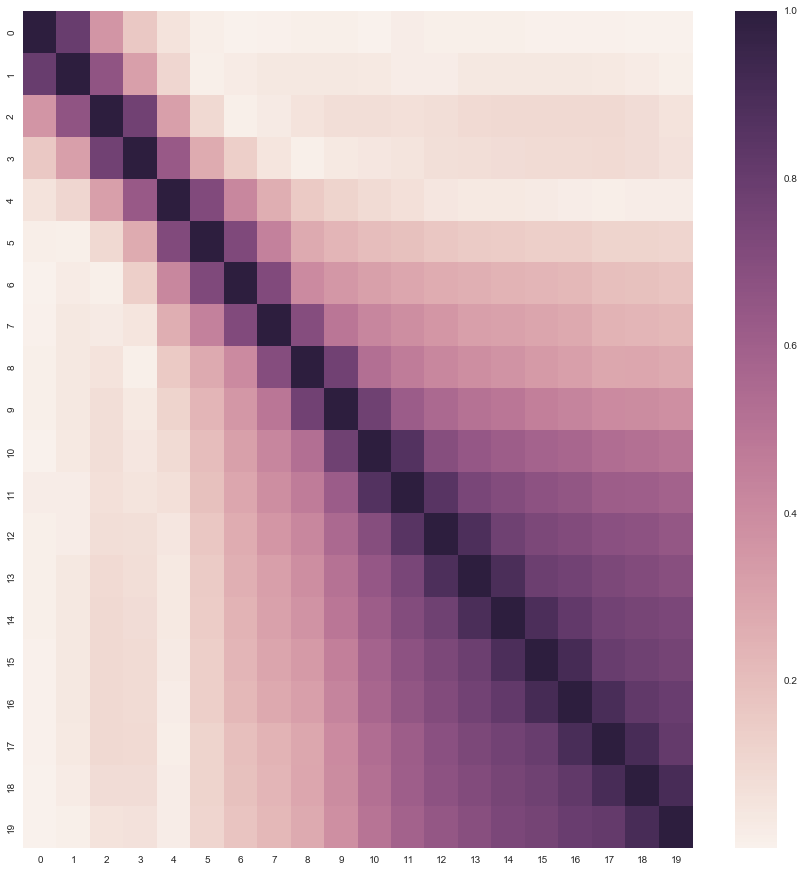

In [20]:
plt.figure(figsize = (15,15))
sns.heatmap(XtrainDf.corr().abs())

In [21]:
XtrainDf.columns

RangeIndex(start=0, stop=20, step=1)

In [22]:
allCols = XtrainDf.columns
tempDf = XtrainDf.corr().abs().unstack().reset_index()
tempDf = tempDf[tempDf.level_0 != tempDf.level_1]
deletedCols = []
while tempDf[0].max() > 0.80:
    a = tempDf[tempDf[0] == tempDf[0].max()]
    if tempDf[tempDf.level_0 == a.iloc[0,0]][0].sum() > tempDf[tempDf.level_0 == a.iloc[0,1]][0].sum() :
        allCols = allCols.drop(a.iloc[0,0])
        deletedCols.append(a.iloc[0,0])
    else:
        allCols = allCols.drop(a.iloc[0,1])
        deletedCols.append(a.iloc[0,1])
    tempDf =  XtrainDf[allCols].corr().abs().unstack().reset_index()
    tempDf = tempDf[tempDf.level_0 != tempDf.level_1]

In [23]:
allCols

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 19], dtype='int64')

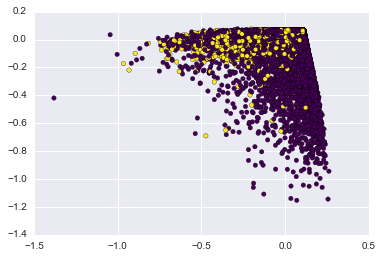

In [24]:
from sklearn import decomposition
pca = decomposition.PCA(n_components = 3)
x_train_pca = pca.fit_transform(XtrainDf[allCols])
plt.set_cmap('viridis')
plt.scatter(x_train_pca[:,0], x_train_pca[:,1], c = y_train[y_train.index.sort_values()] )

### Try a random forest classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
RFClassifier = RandomForestClassifier(random_state = 42, max_depth = 6, n_estimators = 100)
X_train_tree = RFClassifier.fit(XtrainDf[allCols], y_train[y_train.index.sort_values()] )
score = cross_val_score(RFClassifier, XtrainDf[allCols], y_train[y_train.index.sort_values()] )
print score

[ 0.80328358  0.79447761  0.83283582]


In [ ]:
y_train.shape